# MODEL APPLICATION

## Objectives

*   Create Extra Trees Regression model created inthe previous notebook.

*   Test the model on Building IS: *4620142679775*

*   Test the model on Building ID: *6492*

*   Apply the model on the entire dataset.

# IMPORT DATA

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid') 
font = {'weight' : 'bold', 'size' : 23}
matplotlib.rc('font', **font)
plt.style.use('seaborn')

pd.set_option('display.max_columns',0)

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.ensemble import ExtraTreesRegressor


import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv('/CSV_Files/thermostat_single_building_data.csv').drop(['Unnamed: 0', 'temp_diff'], axis=1)
df['ts'] = pd.to_datetime(df['ts'])
ts = df.set_index('ts')
ts.index = pd.to_datetime(ts.index, unit='s')
ts.head()

,outdoor_temp,boiler_on,indoor_temp
ts,,,
2020-11-17 20:24:00,51.998,1.0,73.7375
2020-11-17 20:25:00,51.895,1.0,73.7375
2020-11-17 20:26:00,51.792,1.0,73.7375
2020-11-17 20:27:00,51.331,1.0,73.7375
2020-11-17 20:28:00,51.343,1.0,73.7375


# BASE MODEL

## Functions

In [5]:
def plot_feature_importances(model, X):
    
    """
    Function to plot regression model's feature importances.
    This model must be fitted to the X and y.

    ----------
    
    Args:
        model: The regression model fitted to the data.
        X: Model predictors.
    
    Returns:
        A vertical bar plot with the predictors in the model
        and their feature importance value calculated by
        ensemble methods .feature_importance method.
    
    """
    
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values, fontsize=13) 
    plt.xlabel('Feature importance', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    plt.title('Feature Importance Plot', fontsize=20)

In [6]:
def feature_importance_df(model, X):
    """
    Function to create a pandas feature importance dataframe and plot a bar graph.

    -----------

    Args:
      model: Pipeline model name.
      X: Predictor dataframe. It is used for predictor column names in the model.
    Returns:
      Descending feature importance dataframe as features are indices.
      Feature importances bar plot.

    """
    coefs = pd.DataFrame(
               model.named_steps['m'].feature_importances_,
               columns=['Feature_Importances'], index=X.columns
               )
    coefs['Feature_Importances'] = round(coefs['Feature_Importances'],5)
    coefs = coefs.sort_values(by='Feature_Importances', ascending=False)

    fig = plt.figure(figsize=(18,8))
    ax1 = fig.add_subplot(121)
    ax1.barh(y=coefs.index, width=coefs['Feature_Importances'])
    ax1.set_title('Feature Importances', fontsize=14)

    ax2 = fig.add_subplot(122)
    font_size=12
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = coefs.values, rowLabels = coefs.index, bbox=bbox, colLabels=coefs.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    plt.tight_layout()

In [7]:
def regression_modeling(regressor, scaler, name):

    """
    Function to apply a regression model with a pipeline.
     
      - Pipeline is created with the regressor and scaler.
      - Pipeline is fit to X_train and y_train.
      - Prediction is created for X_test.

    ----------

    Args:
      regressor : Initiated regression method.
      scaler    : Initiated standardization method.
      name      : Name of the regression model.

    Returns:
      - Print train and test scores.
      - Print mean squared error value.
      - Returns feature_importance_df function refults.
          * A feature importance dataframe and a bar plot.    
    """
    
    pipeline = Pipeline([('ss', scaler),
                         ('m', regressor)])
    
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    print('Train Score : ', round(pipeline.score(X_train, y_train),5))
    print('Test Score  : ', round(pipeline.score(X_test, y_test),5), '\n')

    mse = round(mean_squared_error(y_test, y_pred),5)
    print(name+' Mean Squared Error : ', mse)
    print('\n\n')

    feature_importance_df(pipeline, X_train)

## Predictor and Target Variables

In [8]:
ts_multi = ts.copy()

for col in ts_multi.columns:
    for i in range(1,5):
        ts_multi[col+str(i)+'_min_ago'] = ts_multi[col].shift(i)

ts_multi.dropna(inplace=True)
ts_multi.head(10)

,outdoor_temp,boiler_on,indoor_temp,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago
ts,,,,,,,,,,,,,,,
2020-11-17 20:28:00,51.343,1.0,73.7375,51.331,51.792,51.895,51.998,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:29:00,51.100,1.0,73.7375,51.343,51.331,51.792,51.895,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:30:00,50.973,1.0,73.7375,51.100,51.343,51.331,51.792,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:31:00,50.131,1.0,73.7375,50.973,51.100,51.343,51.331,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:32:00,49.825,1.0,73.7375,50.131,50.973,51.100,51.343,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:33:00,50.060,1.0,73.5685,49.825,50.131,50.973,51.100,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:34:00,49.813,1.0,73.5685,50.060,49.825,50.131,50.973,1.0,1.0,1.0,1.0,73.5685,73.7375,73.7375,73.7375
2020-11-17 20:35:00,50.612,1.0,73.5685,49.813,50.060,49.825,50.131,1.0,1.0,1.0,1.0,73.5685,73.5685,73.7375,73.7375
2020-11-17 20:36:00,50.717,1.0,73.5685,50.612,49.813,50.060,49.825,1.0,1.0,1.0,1.0,73.5685,73.5685,73.5685,73.7375


In [9]:
#Create target column to compare predictions
target = ts_multi[['indoor_temp']].shift(periods=-5)
target.dropna(inplace=True)
target.head(10)

,indoor_temp
ts,
2020-11-17 20:28:00,73.5685
2020-11-17 20:29:00,73.5685
2020-11-17 20:30:00,73.5685
2020-11-17 20:31:00,73.5685
2020-11-17 20:32:00,73.5685
2020-11-17 20:33:00,73.5685
2020-11-17 20:34:00,73.8495
2020-11-17 20:35:00,73.8495
2020-11-17 20:36:00,73.8495


In [10]:
print(len(ts_multi), len(target))
ts_multi = ts_multi[:len(target)]
print(len(ts_multi), len(target))

41894 41889
41889 41889


In [11]:
X = ts_multi.copy()
y = target.copy()

## ExtraTreesRegressor Model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=123)

In [31]:
ets_reg = ExtraTreesRegressor(criterion='mse',
                              random_state=123)
scaler = StandardScaler()

pipeline_ets = Pipeline([('ss', scaler),
                         ('m', ets_reg)])

pipeline_ets.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('m',
                 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                     criterion='mse', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=123,
                                     verbose=0, warm_start=False))],
         verbose=False)

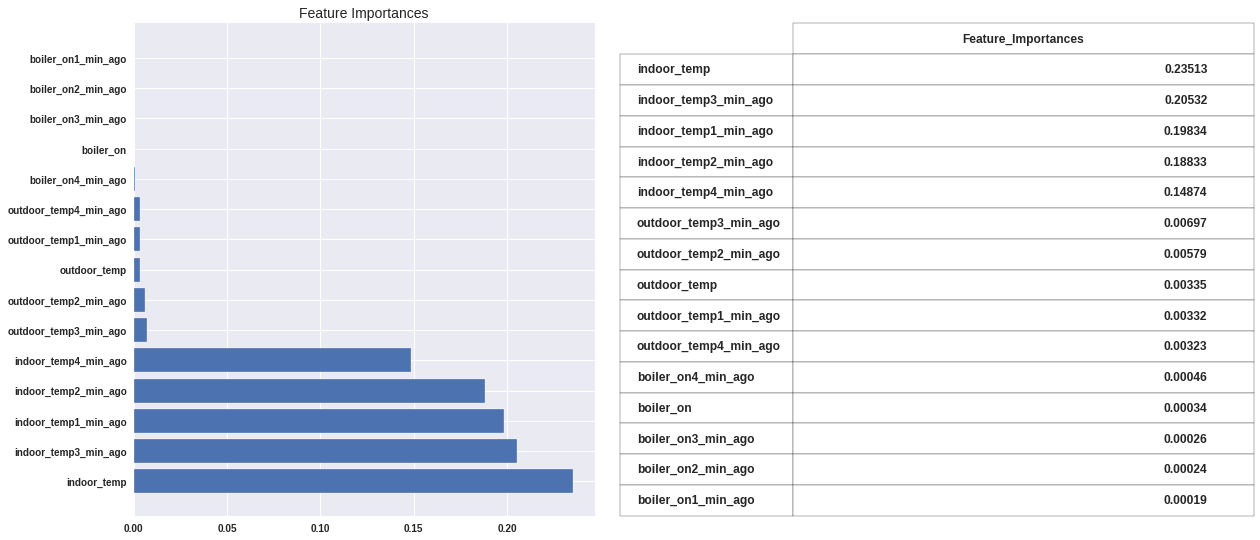

In [32]:
feature_importance_df(pipeline_ets, X_train)

# TESTING THE MODEL

We create subsets for different buildings and apply our model to our newly created data. This serves to see if our model is generally applicable to the buildings in the New York State area. For modeling, we use the model with the least Mean Squared Error value, Extra Trees Regressor. 

In [56]:
thermostat_df = pd.read_csv('/CSV_Files/thermostat_modeling_data.csv').drop(['Unnamed: 0', 'temp_diff'], axis=1)
thermostat_df.head()

,building_id,ts,outdoor_temp,boiler_on,indoor_temp
0,6294,2020-11-17 20:24:00,46.748,0.0,76.6015
1,6294,2020-11-17 20:25:00,46.798,0.0,76.6015
2,6294,2020-11-17 20:26:00,46.810,0.0,76.6015
3,6294,2020-11-17 20:27:00,46.636,0.0,76.6015
4,6294,2020-11-17 20:28:00,46.224,0.0,76.6015


In [57]:
thermostat_df['building_id'].nunique()

78

In [58]:
# We created a new dataset with the buildings that have complete data.

building_ids = [6294, 6492, 6537, 6603, 6669, 6690, 6834, 7167, 7530, 7791, 7899, 8286, 8295, 8331, 8349, 8361, 8385, 
                4599162238458, 4601239477806, 4608783572670, 4613394659241, 4620142679775, 4628427107424, 4635426411159, 
                4639327012671, 4639327530792, 4644520776144, 4650760008126, 4655156826969, 4655701297074, 4656183892830, 
                4656959670501, 4659019937640, 4681584686799, 4693757244189, 4696855216602, 4697172397914, 4697386420251, 
                4697933506509, 4699461536766, 4706758208598, 4706762863053, 4711164238872, 4715512009560, 4721030218707, 
                4721540442747, 4721542229706, 4721545602825, 4731619739994, 4734998883585, 4753626976665, 4756727821203, 
                4776689811420, 4785563955429, 4817919582339]  

In [59]:
thermostat_df = thermostat_df.loc[thermostat_df['building_id'].isin(building_ids)]
thermostat_df.head()

,building_id,ts,outdoor_temp,boiler_on,indoor_temp
0,6294,2020-11-17 20:24:00,46.748,0.0,76.6015
1,6294,2020-11-17 20:25:00,46.798,0.0,76.6015
2,6294,2020-11-17 20:26:00,46.810,0.0,76.6015
3,6294,2020-11-17 20:27:00,46.636,0.0,76.6015
4,6294,2020-11-17 20:28:00,46.224,0.0,76.6015


In [60]:
# Check for duplicates
print('There are {} data points in the datarame before the duplicates are dropped.'.format(len(thermostat_df)))
print('There are {} duplicate rows in the data.'.format(thermostat_df.duplicated(subset=['building_id', 'ts', 'boiler_on', 'indoor_temp']).sum()))
thermostat_df.drop_duplicates(subset=['building_id', 'ts', 'boiler_on', 'indoor_temp'], inplace=True)
print('There are {} data points left in the datarame after the duplicates are dropped.'.format(len(thermostat_df)))

There are 2007480 data points in the datarame before the duplicates are dropped.
There are 0 duplicate rows in the data.
There are 2007480 data points left in the datarame after the duplicates are dropped.


In [61]:
thermostat_df.isnull().sum()

building_id     0
ts              0
outdoor_temp    0
boiler_on       0
indoor_temp     0
dtype: int64

In [62]:
thermostat_df = thermostat_df.set_index('ts')
thermostat_df.index = pd.to_datetime(thermostat_df.index)
thermostat_df

,building_id,outdoor_temp,boiler_on,indoor_temp
ts,,,,
2020-11-17 20:24:00,6294,46.748,0.0,76.6015
2020-11-17 20:25:00,6294,46.798,0.0,76.6015
2020-11-17 20:26:00,6294,46.810,0.0,76.6015
2020-11-17 20:27:00,6294,46.636,0.0,76.6015
2020-11-17 20:28:00,6294,46.224,0.0,76.6015
...,...,...,...,...
2020-12-17 20:17:00,4817919582339,33.489,0.0,72.3200
2020-12-17 20:18:00,4817919582339,33.410,0.0,72.3200
2020-12-17 20:19:00,4817919582339,33.346,0.0,72.3200


In [64]:
# Save this dataset.
thermostat_df.to_csv('/CSV_Files/thermostat_df.csv')

## Model Test with ID 4620142679775

### Predictor and Target Variables

In [41]:
ts_1 = thermostat_df[thermostat_df['building_id'] == 4620142679775]
ts_1.drop('building_id', axis=1, inplace=True)
ts_1.head()

,outdoor_temp,boiler_on,indoor_temp
ts,,,
2020-11-17 20:24:00,46.274,0.0,70.9245
2020-11-17 20:25:00,46.449,0.0,70.9245
2020-11-17 20:26:00,46.574,0.0,70.9245
2020-11-17 20:27:00,46.822,0.0,70.9245
2020-11-17 20:28:00,46.736,0.0,70.9245


In [42]:
# Create predictors dataset with previous 4 minutes' data
for col in ts_1.columns:
    for i in range(1,5):
        ts_1[col+str(i)+'_min_ago'] = ts_1[col].shift(i)

ts_1.dropna(inplace=True)
X_1 = ts_1.copy()
X_1.head()

,outdoor_temp,boiler_on,indoor_temp,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago
ts,,,,,,,,,,,,,,,
2020-11-17 20:28:00,46.736,0.0,70.9245,46.822,46.574,46.449,46.274,0.0,0.0,0.0,0.0,70.9245,70.9245,70.9245,70.9245
2020-11-17 20:29:00,46.760,0.0,70.9245,46.736,46.822,46.574,46.449,0.0,0.0,0.0,0.0,70.9245,70.9245,70.9245,70.9245
2020-11-17 20:30:00,46.673,0.0,70.9245,46.760,46.736,46.822,46.574,0.0,0.0,0.0,0.0,70.9245,70.9245,70.9245,70.9245
2020-11-17 20:31:00,46.835,0.0,70.9245,46.673,46.760,46.736,46.822,0.0,0.0,0.0,0.0,70.9245,70.9245,70.9245,70.9245
2020-11-17 20:32:00,46.860,0.0,70.8685,46.835,46.673,46.760,46.736,0.0,0.0,0.0,0.0,70.9245,70.9245,70.9245,70.9245


In [43]:
#Create target column to compare predictions
y_1 = ts_1[['indoor_temp']].shift(periods=-5)
y_1.dropna(inplace=True)
y_1.head()

,indoor_temp
ts,
2020-11-17 20:28:00,70.8685
2020-11-17 20:29:00,70.7560
2020-11-17 20:30:00,70.7560
2020-11-17 20:31:00,70.8640
2020-11-17 20:32:00,70.8120


In [44]:
print(len(X_1), len(y_1))
X_1 = X_1[:len(y_1)]
print(len(X_1), len(y_1))

41894 41889
41889 41889


### Testing

In [45]:
pred_train_1 = pipeline_ets.predict(X_train)
pred_test_1 = pipeline_ets.predict(X_1)

print('Train Score : ', round(pipeline_ets.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_ets.score(X_1, y_1),5), '\n')

mse_train_1 = round(mean_squared_error(y_train, pred_train_1),5)
mse_test_1 = round(mean_squared_error(y_1, pred_test_1),5)
print('Train Mean Squared Error of Building ID - 4620142679775: ', mse_train_1)
print('Test Mean Squared Error of Building ID - 4620142679775: ', mse_test_1)

Train Score :  1.0
Test Score  :  0.87273 

Train Mean Squared Error of Building ID - 4620142679775:  0.0
Test Mean Squared Error of Building ID - 4620142679775:  0.17337


### ***Observations***

*   Our pilot model's MSE is 0.03094
*   For Building ID: 4620142679775, new MSE is 0.172.

## Model Test with ID 6492

### Predictor and Target Variables

In [46]:
ts_2 = thermostat_df[thermostat_df['building_id'] == 6492]
ts_2.drop('building_id', axis=1, inplace=True)

# Create predictors dataset with previous 4 minutes' data
for col in ts_2.columns:
    for i in range(1,5):
        ts_2[col+str(i)] = ts_2[col].shift(i)

ts_2.dropna(inplace=True)
X_2 = ts_2.copy()

#Create target column to compare predictions
y_2 = ts_2[['indoor_temp']].shift(periods=-5)
y_2.dropna(inplace=True)

In [47]:
print(len(X_2), len(y_2))
X_2 = X_2[:len(y_2)]
print(len(X_2), len(y_2))

11408 11403
11403 11403


### Testing

In [48]:
pred_train_2 = pipeline_ets.predict(X_train)
pred_test_2 = pipeline_ets.predict(X_2)

print('Train Score : ', round(pipeline_ets.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_ets.score(X_2, y_2),5), '\n')

mse_train_2 = round(mean_squared_error(y_train, pred_train_2),5)
mse_test_2 = round(mean_squared_error(y_2, pred_test_2),5)
print('Train Mean Squared Error of Building ID - 6492: ', mse_train_2)
print('Test Mean Squared Error of Building ID - 6492: ', mse_test_2)

Train Score :  1.0
Test Score  :  0.84695 

Train Mean Squared Error of Building ID - 6492:  0.0
Test Mean Squared Error of Building ID - 6492:  0.24543


### ***Observations***

*   Our pilot model's MSE is 0.03094
*   For Building ID: 6492, new MSE is 0.268.

# MODELING WITH COMPLETE DATASET

## Predictors and Target Variables

In [65]:
ts_ = thermostat_df.copy()
ts_.drop('building_id', axis=1, inplace=True)

for col in ts_.columns:
    for i in range(1,5):
        ts_[col+str(i)] = ts_[col].shift(i)

ts_.dropna(inplace=True)
X = ts_.copy()
X.head()

,outdoor_temp,boiler_on,indoor_temp,outdoor_temp1,outdoor_temp2,outdoor_temp3,outdoor_temp4,boiler_on1,boiler_on2,boiler_on3,boiler_on4,indoor_temp1,indoor_temp2,indoor_temp3,indoor_temp4
ts,,,,,,,,,,,,,,,
2020-11-17 20:28:00,46.224,0.0,76.6015,46.636,46.810,46.798,46.748,0.0,0.0,0.0,0.0,76.6015,76.6015,76.6015,76.6015
2020-11-17 20:29:00,46.362,0.0,76.6015,46.224,46.636,46.810,46.798,0.0,0.0,0.0,0.0,76.6015,76.6015,76.6015,76.6015
2020-11-17 20:30:00,46.586,0.0,76.6015,46.362,46.224,46.636,46.810,0.0,0.0,0.0,0.0,76.6015,76.6015,76.6015,76.6015
2020-11-17 20:31:00,46.437,0.0,76.5455,46.586,46.362,46.224,46.636,0.0,0.0,0.0,0.0,76.6015,76.6015,76.6015,76.6015
2020-11-17 20:32:00,46.337,0.0,76.5455,46.437,46.586,46.362,46.224,0.0,0.0,0.0,0.0,76.5455,76.6015,76.6015,76.6015


In [66]:
#Create target column to compare predictions
y = ts_[['indoor_temp']].shift(periods=-5)
y.dropna(inplace=True)
y.head()

,indoor_temp
ts,
2020-11-17 20:28:00,76.5455
2020-11-17 20:29:00,76.5455
2020-11-17 20:30:00,76.5455
2020-11-17 20:31:00,76.5455
2020-11-17 20:32:00,76.5455


In [67]:
print(len(X), len(y))
X = X[:len(y)]
print(len(X), len(y))

2007476 2007471
2007471 2007471


## Modeling

In [68]:
pred_train = pipeline_ets.predict(X_train)
pred_test = pipeline_ets.predict(X)

print('Train Score : ', round(pipeline_ets.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_ets.score(X, y),5), '\n')

mse_train = round(mean_squared_error(y_train, pred_train),5)
mse_test = round(mean_squared_error(y, pred_test),5)
print('Train Mean Squared Error of 38 Buildings: ', mse_train)
print('Test Mean Squared Error of 38 Building: ', mse_test)

Train Score :  1.0
Test Score  :  0.84712 

Train Mean Squared Error of 38 Buildings:  0.0
Test Mean Squared Error of 38 Building:  0.82027


### ***Observations***

*   The MSE of the 38 buildings in the data is 0.803. It is very close to 1.
*   We can assume each building has different varriations in effect and the same model provides different results for different buildings. 




# CONCLUSION


*   Extra Trees Regressor Model provide the least Mean Squared Error value for for the multivariate regression models. This value is also better than univariate regression models.

*   Our base model has an MSE of 0.031.

*   This model significantly relies on indoor temperatures.

*   We continue analysis by applying the same regression model to the different buildings' data to see how applicable our model is. 

*   We apply this model to 2 different buildings and calculate MSEs of 0.172 and 0.267, which are higher that the base model.

*   This is an indication of that our model is not widely applicable.

*   Later we continue applying the model to all 38 buildings in New York State. For this data, our MSE is 0.82, which is very close to 1.

*   It is safe to say that this model is not widely applicable. 


# SUGGESTION



*   Our model is not widely applicable. Next step can be creating a base model with a random sample data from the all data set instead of using one building's data.

*   Our models significantly rely on indoor temperature, especialy the latest indoor temperature value most of the times. (We observed this in the previous notebook.)

*   From exploratory data analysis, we observed that indoor temperature doesn't change within 5 minutes time frame most of the time. We can change our target from shifted indoor temperature to indoor temperature difference. 

*   For the indoor temperature difference model, we can eliminate data where there is no change.
